In [1]:
import numpy as np
import GPy
from pylab import *
from sys import path
np.random.seed(42)
import numpy as np
import pandas as pd

import deepgp
from sklearn.preprocessing import MinMaxScaler
# TODO: You might need to normalize the input and/or output data.


In [12]:
# # data= pd.read_excel('positive_negative_volatility_per_currency.xlsx',sheet_name = 'USD_JPY_Negative Volatility',header=None)
# data = pd.read_excel('positive_negative_volatility_per_currency.xlsx', sheet_name = 'GBP_USD_Positive Volatility', header = None)
# data=data.dropna(axis=0,how='any')
# x=np.linspace(0,len(data)-1,len(data)-1)
# y=data.iloc[30:,1].values.astype(float)
# y=(y-y.min())/(y.max()-y.min())
# sample_length=30
# sample_num=len(y)//sample_length
# x_all=[]
# y_all=[]
# # for i in range(sample_num):
#     # x_all.append(x[i*sample_length:(i+1)*sample_length])
#     # y_all.append(y[i*sample_length:(i+1)*sample_length])
# 
# 
# for i in range(sample_num-1):
#     x_all.append(y[i*sample_length:(i+1)*sample_length])
#     y_all.append(y[(i+1)*sample_length:(i+2)*sample_length])
#     
#     
# x_all=np.array(x_all)
# y_all=np.array(y_all) 
# X_train=x_all[:int(len(x_all)*0.6)]
# Y_train=y_all[:int(len(x_all)*0.6)]
# X_test=x_all[int(len(x_all)*0.6):]
# Y_test=y_all[int(len(x_all)*0.6):]
X_train = np.linspace(0, 2.5, 40).reshape(-1, 1).T
def m(x):
    coefs = [5, -2.5, -2.4, -0.2, 0.3, 0.04]
    total = 0
    for exp, coef in enumerate(coefs):
        total += coef * (x ** exp)
    return total

Y_train = m(X_train).reshape(-1, 1).T

X_test = np.linspace(0, 2.5, 40).reshape(-1, 1).T
Y_test = m(X_test).reshape(-1, 1).T


In [13]:
Y_train.shape

(1, 40)

In [14]:
# len(x_all)

In [15]:
#--------- Model Construction ----------#
# Number of latent dimensions (single hidden layer, since the top layer is observed)
Q = 1
# Define what kernels to use per layer
kern1 = GPy.kern.RBF(Q,ARD=True) + GPy.kern.Bias(Q)
kern2 = GPy.kern.RBF(X_train.shape[1],ARD=False) + GPy.kern.Bias(X_train.shape[1])
# Number of inducing points to use
num_inducing = 40
# Whether to use back-constraint for variational posterior
back_constraint = False
# Dimensions of the MLP back-constraint if set to true
encoder_dims=[[300],[150]]

m = deepgp.DeepGP([Y_train.shape[1],Q,X_train.shape[1]],Y_train, X=X_train,kernels=[kern1, kern2], num_inducing=num_inducing, back_constraint=back_constraint)




 C:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\GPy\util\pca.py:64: RuntimeWarning:divide by zero encountered in divide
 C:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\GPy\util\pca.py:64: RuntimeWarning:invalid value encountered in multiply
 C:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\GPy\util\pca.py:38: RuntimeWarning:invalid value encountered in divide


In [16]:
#--------- Optimization ----------#
# Make sure initial noise variance gives a reasonable signal to noise ratio.
# Fix to that value for a few iterations to avoid early local minima
for i in range(len(m.layers)):
    output_var = m.layers[i].Y.var() if i==0 else m.layers[i].Y.mean.var()
    m.layers[i].Gaussian_noise.variance = output_var*0.01
    m.layers[i].Gaussian_noise.variance.fix()

m.optimize(max_iters=10000, messages=True)
# Unfix noise variance now that we have initialized the model
for i in range(len(m.layers)):
    m.layers[i].Gaussian_noise.variance.unfix()

m.optimize(max_iters=1500, messages=True)



In [17]:
#--------- Inspection ----------#
# Compare with GP
m_GP = GPy.models.SparseGPRegression(X=X_train, Y=Y_train, kernel=GPy.kern.RBF(X_train.shape[1])+GPy.kern.Bias(X_train.shape[1]), num_inducing=num_inducing)
m_GP.Gaussian_noise.variance = m_GP.Y.var()*0.01
m_GP.Gaussian_noise.variance.fix()
m_GP.optimize(max_iters=100, messages=True)
m_GP.Gaussian_noise.variance.unfix()
m_GP.optimize(max_iters=400, messages=True)

def mse(predictions, targets):
    return ((predictions.flatten() - targets.flatten()) ** 2).mean()

Y_pred = m.predict(X_test)[0]
Y_pred_s = m.predict_withSamples(X_test, nSamples=500)[0]
Y_pred_GP = m_GP.predict(X_test)[0]

# DeepGP isn't expected to outperform GPs always (especially on simple problems like this one here)
print('# RMSE DGP               : ' + str(mse(Y_pred, Y_test)))
print('# RMSE DGP (with samples): ' + str(mse(Y_pred_s, Y_test)))
print('# RMSE GP                : ' + str(mse(Y_pred_GP, Y_test)))


# RMSE DGP               : nan
# RMSE DGP (with samples): nan
# RMSE GP                : 0.0011960658758746522


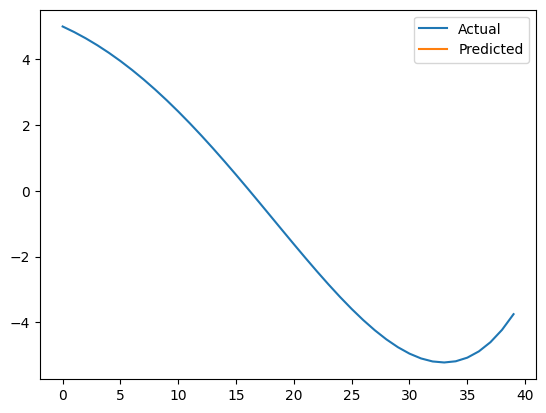

In [19]:
import matplotlib.pyplot as plt
show_id=0
# plt.plot(X_test[show_id], label='Actual_X')
plt.plot(Y_test[show_id], label='Actual')
plt.plot(Y_pred[show_id], label='Predicted')
plt.legend()
plt.show()


In [9]:
Y_pred.shape

(41, 30)

In [10]:
Y_pred_plot=Y_pred.reshape(-1)
Y_test_plot=Y_test.reshape(-1)

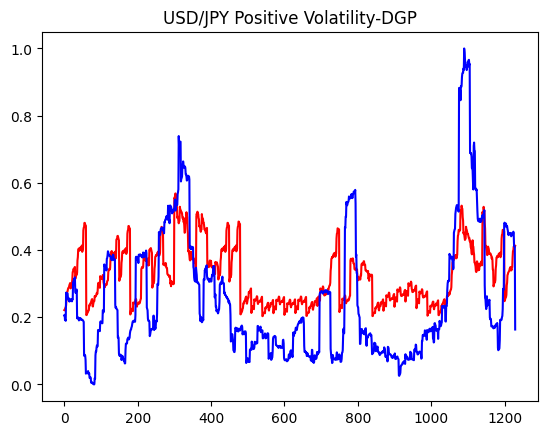

In [11]:
x = np.arange(len(Y_pred_plot))

# 绘制折线图，以索引为x轴，一维数组元素值为y轴
plt.plot(x, Y_pred_plot,'-r')
plt.plot(x, Y_test_plot,'-b')

# 添加标题、坐标轴标签等让图表更清晰可读
# plt.title('USD/JPY Positive Volatility-DGP')
plt.title('USD/JPY Negative Volatility-DGP')

# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.savefig("USD_JPY Positive Volatility - DGP.png",dpi=300)
plt.savefig("USD_JPY Negative Volatility - DGP.png",dpi=300)
plt.show()

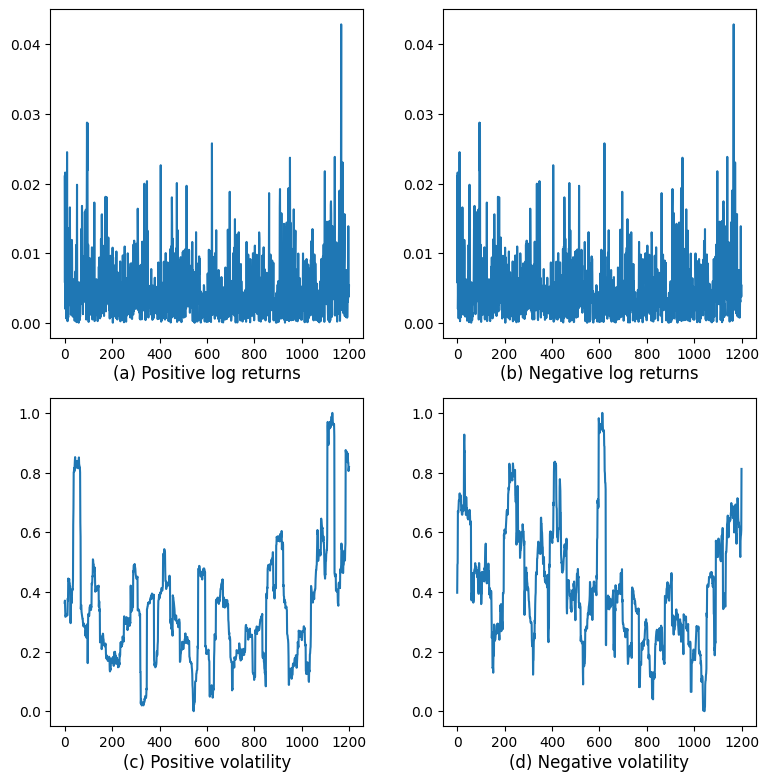

In [65]:


# 生成示例数据，这里为了方便演示，使用简单的随机数据，你可以替换为真实数据
data1 = pd.read_excel('positive_negative_volatility_per_currency.xlsx', sheet_name = 'USD_JPY_Positive Returns', header = None).dropna(axis=0,how='any').iloc[1:1+1200,1].values.astype(float)
data2 = pd.read_excel('positive_negative_volatility_per_currency.xlsx', sheet_name = 'USD_JPY_Positive Returns', header = None).dropna(axis=0,how='any').iloc[1:1+1200,1].values.astype(float)
data3 = pd.read_excel('positive_negative_volatility_per_currency.xlsx', sheet_name = 'USD_JPY_Positive Volatility', header = None).dropna(axis=0,how='any').iloc[30:30+1200,1].values.astype(float)
data4 = pd.read_excel('positive_negative_volatility_per_currency.xlsx', sheet_name = 'USD_JPY_Negative Volatility', header = None).dropna(axis=0,how='any').iloc[30:30+1200,1].values.astype(float)

# plt.figure(figsize=(10, 10))
data3=(data3-data3.min())/(data3.max()-data3.min())
data4=(data4-data4.min())/(data4.max()-data4.min())
# 创建一个包含2x2个子图的画布，fig是整个画布对象，axs是包含各个子图的数组
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.subplots_adjust(hspace=1000.0)
# 在第一个子图中绘制图形
axs[0, 0].plot(data1)
axs[0, 0].set_title('(a) Positive log returns', y=-0.15)

# 在第二个子图中绘制图形
axs[0, 1].plot(data2)
axs[0, 1].set_title('(b) Negative log returns', y=-0.15)

# 在第三个子图中绘制图形
axs[1, 0].plot(data3)
axs[1, 0].set_title('(c) Positive volatility', y=-0.15)

# 在第四个子图中绘制图形
axs[1, 1].plot(data4)
axs[1, 1].set_title('(d) Negative volatility', y=-0.15)

# 设置整个画布的标题（可选）
# fig.suptitle('Four Subplots in One Figure')

# 调整子图之间的间距，让布局更合理美观（可选）
plt.tight_layout(rect=[0, 0.01, 1, 1])
plt.savefig('subplots_image.png', dpi=300)
# 显示图形
plt.show()

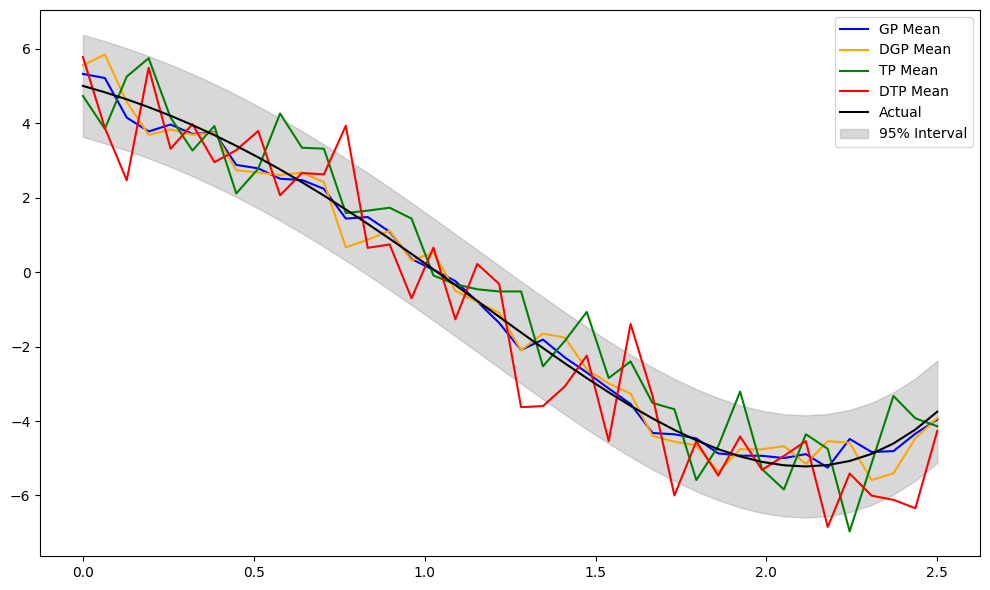

In [36]:
data_GP = pd.read_csv('samples_GP.csv', header=None)
data_DGP = pd.read_csv('samples_DGP.csv', header=None)
data_TP = pd.read_csv(r"D:\pycharm_test\DTP\samples_TP.csv", header=None)
data_DTP = pd.read_csv(r"D:\pycharm_test\DTP\samples_DTP.csv", header=None)

# Determine the number of points and define x accordingly
# If you know the actual x-values, use them. Otherwise, just assume a range.
# n = data_GP.shape[0]
x = np.linspace(0, 2.5, 40)  # Example: from -1 to 1
def m(x):
    coefs = [5, -2.5, -2.4, -0.2, 0.3, 0.04]
    total = 0
    for exp, coef in enumerate(coefs):
        total += coef * (x ** exp)
    return total

def k(xs, ys, sigma=0.7, l=0.04):
    dx = np.expand_dims(xs, 1) - np.expand_dims(ys, 0)
    tmp = (sigma ** 2) * np.exp(-((dx / l) ** 2) / 2)
    return tmp

y=m(x)
# Compute means and standard deviations across samples (axis=1 means row-wise)
mean_GP = data_GP.mean(axis=0)
# std_GP = data_GP.std(axis=1)

mean_DGP = data_DGP.mean(axis=0)
# std_DGP = data_DGP.std(axis=1)

mean_TP = data_TP.mean(axis=0)
# std_TP = data_TP.std(axis=1)

mean_DTP = data_DTP.mean(axis=0)
# std_DTP = data_DTP.std(axis=1)

# Create the plot
fig, ax = plt.subplots(figsize=(10,6))

# Plot GP mean and interval
ax.plot(x, mean_GP, label='GP Mean', color='blue')
# ax.fill_between(x, mean_GP - 1.96 * std_GP, mean_GP + 1.96 * std_GP, alpha=0.3, color='blue', label='GP 95% Interval')

# Plot DGP mean and interval
ax.plot(x, mean_DGP, label='DGP Mean', color='orange')
# ax.fill_between(x, mean_DGP - 1.96 * std_DGP, mean_DGP + 1.96 * std_DGP, alpha=0.3, color='orange', label='DGP 95% Interval')

# Plot TP mean and interval
ax.plot(x, mean_TP, label='TP Mean', color='green')
# ax.fill_between(x, mean_TP - 1.96 * std_TP, mean_TP + 1.96 * std_TP, alpha=0.3, color='green', label='TP 95% Interval')

# Plot DTP mean and interval
ax.plot(x, mean_DTP, label='DTP Mean', color='red')
# ax.fill_between(x, mean_DTP - 1.96 * std_DTP, mean_DTP + 1.96 * std_DTP, alpha=0.3, color='red', label='DTP 95% Interval')

ax.plot(x,y,label='Actual',color='black')
epsilon = 1e-6  # 对角扰动的值，可以根据需要调整
Sigma = k(x,x) + epsilon
stds = np.sqrt(Sigma.diagonal())
ax.fill_between(x, y - 1.96 * stds, y + 1.96 * stds, alpha=0.3, color='gray',label='95% Interval')

# ax.set_title("Comparison of GP, DGP, TP, and DTP Means and 95% Predictive Intervals")
# ax.set_xlabel("X")
# ax.set_ylabel("Value")
ax.legend()
# plt.grid(True)
plt.tight_layout()

plt.savefig("comparison_plot.png", dpi=300)
plt.show()